# Homework 3

In [1]:
!pip install networkx==2.6.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.5 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 2.8.8
    Uninstalling networkx-2.8.8:
      Successfully uninstalled networkx-2.8.8


In [2]:
import networkx as nx
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

sns.set()
sns.set_style(style="whitegrid")
sns.set_color_codes("colorblind")

SEED = 0

In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/Network Dynamics and Learning/H3

/content/drive/MyDrive/Colab Notebooks/Network Dynamics and Learning/H3


# H1N1 epidemics

## Problem 1.1

In [4]:
def symmetric_k_regular_graph(n_nodes, k):
    """
    This function defines a symmetric `k`-regular undirected graph with `n_nodes`
    nodes with `k` neighbors each.

    n_nodes:    number of nodes in the graph
    k:  number of neighbors for each node
    """

    # the base for this graph is a cycle
    G = nx.cycle_graph(n_nodes)

    # for each node add the edges that do not compose the main cycle
    for n in G.nodes():
        for ki in range(2, int(k / 2) + 1):
            G.add_edge(n,((n + ki) % n_nodes))
            G.add_edge(n,((n - ki) % n_nodes))

    return G

In [ ]:
G = symmetric_k_regular_graph(n_nodes=12, k=4)

pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, linewidths=3, edgecolors="#000000")
nx.draw(G, pos, node_color="#ffffff", with_labels=True)

plt.savefig("./p1_1_graph.pdf", bbox_inches="tight")

In [6]:
def simulate_SIR(G, n_simulations, weeks, n_init_infected, beta, rho, conditions, seed=None):
    """
    This function simulates the evolution of a SIR epidemics over a finite number
    of weeks on the social network defined by the graph.

    G:  graph that defines the social network over which the epidemics happen
    n_simultaions:  number of simulations
    weeks:  number of weeks over which the epidemics happen
    n_init_infected:    number of infection in the week 0
    beta:   infection ratio
    rho:    recovery rate
    conditions: the dictionary with association between states and a number
    seed:   to set a seed for reproducibility reasons
    """

    global S, I, R

    # matrix containing the new infected by week and simulation
    new_infected = np.zeros((n_simulations, weeks+1))
    # matrix containing the amount of susceptible, infected, recovered by week
    # and simultaion
    sir_results = np.zeros((n_simulations, len(conditions), weeks+1))

    # reproducibility
    if seed is not None:
        np.random.seed(seed)
    
    # run the simulations
    for n in range(n_simulations):
        # initialize the states
        X = np.array([S] * len(G.nodes()))
        new_infected[n, 0] = n_init_infected
        sir_results[n, :, 0] = [len(G.nodes())-n_init_infected, n_init_infected, 0]

        # select n_init_infected nodes to be the first infected
        init_infected = np.random.choice(G.nodes(), n_init_infected, replace=False)
        # set the state in for these nodes as infected
        X[init_infected] = I

        # run for all the weeks
        for week in range(1, weeks+1):
            # counter of the infected for the week
            infected = 0

            # a copy of the state to be modified
            X_new = deepcopy(X)

            for node in G.nodes():
                # if the node is suceptible
                if X[node] == S:
                    # get the neighbors
                    neighs = list(G.neighbors(node))
                    # count infected neighbors
                    m = sum(X[neighs] == I)
                    # compute probability of being infected given the number of
                    # infected neighbors
                    P_of_I = 1 - (1 - beta)**m
                
                    if np.random.rand() < P_of_I:
                        # the infection happened
                        infected += 1
                        X_new[node] = I

                # if the node is infected
                if X[node] == I:
                    if np.random.rand() < rho:
                        # the recovery happened
                        X_new[node] = R

            # update the states
            new_infected[n][week] = infected
            sir_results[n, :, week] = [sum(np.array(X_new)==S),
                                       sum(np.array(X_new)==I),
                                       sum(np.array(X_new)==R)]
            X = X_new

    return sir_results, new_infected

In [7]:
# define the graph on which we will work
n_nodes = 500
k = 4

G = symmetric_k_regular_graph(n_nodes=n_nodes, k=k)

# come constants
S, I, R = 0, 1, 2
conditions = {S: "Susceptible", I: "Infected", R: "Recovered"}

In [ ]:
# simulate the infection
sir_results, new_infected = simulate_SIR(G, n_simulations=100, weeks=15,
                                         n_init_infected=10, beta=0.3, rho=0.7,
                                         conditions=conditions, seed=SEED)

# compute the average over the simulations
avg_sir_results = np.array(sir_results).mean(axis=0)
avg_new_infected = np.array(new_infected).mean(axis=0)

# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].set_title("SIR epidemics evolution")
for condition in range(3):
    ax[0].plot(range(16), avg_sir_results[condition, :], label=conditions[condition])
ax[0].legend()
ax[0].set_xlabel("Week")
ax[0].set_ylabel("# people")

ax[1].set_title("New infections by week")
ax[1].plot(range(16), avg_new_infected)
ax[1].set_xlabel("Week")
ax[1].set_ylabel("# new infected")

plt.savefig("./p1_1_sir_evolution.pdf", bbox_inches="tight")

## Problem 1.2

In [9]:
def pa_random_graph(n_nodes, k, seed=None):
    """
    This function defines a random graph using the preferential attachment rule
    starting from a complete graph with `k+1` nodes it adds `times` new nodes with
    `k/2` edges each time. In this way the graph will have an average degree of `k`

    k:  average graph degree, used also to define the starting complete graph
    times:  number of nodes to be added
    seed:   for reproducibility
    """

    # define the base graph
    G = nx.complete_graph(k + 1)

    # comput the number of links for each new node
    c = np.floor(k / 2)

    # reproducibility
    if seed is not None:
        np.random.seed(seed)

    # how many time the addition process should be executed
    times = n_nodes - k - 1

    # add a new node for times-1 times
    for t in range(times):
        # a copy of the graph to be modified
        G_new = deepcopy(G)

        # add the new node to the graph
        new_node = len(G.nodes())
        G_new.add_node(new_node)

        # define the probabilities to be attached to each pre-existing node
        p = np.array([G.degree[node] for node in G.nodes()]) / np.sum(np.array([G.degree[node] for node in G.nodes()]))

        # add the c links
        while G_new.degree[new_node] < c:
            # select the node to which to attach
            i = np.random.choice(G.nodes(), p=p)
            # check that the link doesn't already exist
            if i not in G_new.neighbors(new_node):
                G_new.add_edge(new_node, i)

        # update of the graph
        G = G_new

        # in case the average degree is odd we need to add/subtract 1 to keep
        # the average on that number
        if k % 2 != 0:
            c += (-1)**t

    return G

In [ ]:
# example with small graph to be plotted
G = pa_random_graph(n_nodes=12, k=5, seed=SEED)

# plot
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, linewidths=3, edgecolors="#000000")
nx.draw(G, pos, node_color="#ffffff", with_labels=True)

plt.savefig("./p1_2_pa_random_graph.pdf", bbox_inches="tight")

The average degree on the random graph generated with preferential attachment is 20.0.


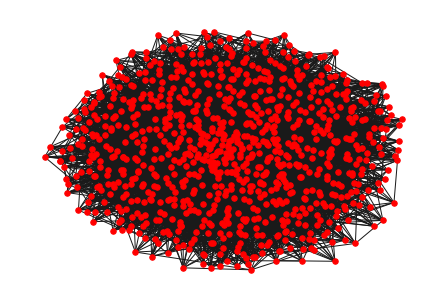

In [11]:
# example with large graph
G = pa_random_graph(n_nodes=900, k=20, seed=SEED)

avg_degree = np.array([G.degree[n] for n in G.nodes()]).mean()
print(f"The average degree on the random graph generated with preferential attachment is {avg_degree}.")

pos = nx.spring_layout(G, seed=SEED)
nx.draw(G, pos=pos, node_size=30, node_color='red')
plt.savefig("./p1_2_pa_900.pdf", bbox_inches="tight")

## Problem 2

In [12]:
# define the graph on which we will work
n_nodes = 500
k = 6

G = pa_random_graph(n_nodes=500, k=k, seed=SEED)

# come constants
S, I, R = 0, 1, 2
conditions = {S: "Susceptible", I: "Infected", R: "Recovered"}

print(f"The number of nodes in the graph is {len(G.nodes())}")
avg_degree = np.array([G.degree[n] for n in G.nodes()]).mean()
print(f"The average degree on the random graph generated with preferential attachment is {avg_degree}.")

The number of nodes in the graph is 500
The average degree on the random graph generated with preferential attachment is 6.0.


In [ ]:
# simulate the infection
sir_results, new_infected = simulate_SIR(G, n_simulations=100, weeks=15,
                                         n_init_infected=10, beta=0.3, rho=0.7,
                                         conditions=conditions, seed=SEED)

# compute the average over the simulations
avg_sir_results = np.array(sir_results).mean(axis=0)
avg_new_infected = np.array(new_infected).mean(axis=0)

# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].set_title("SIR epidemics evolution")
for condition in range(3):
    ax[0].plot(range(16), avg_sir_results[condition, :], label=conditions[condition])
ax[0].legend()
ax[0].set_xlabel("Week")
ax[0].set_ylabel("# people")

ax[1].set_title("New infections by week")
ax[1].plot(range(16), avg_new_infected)
ax[1].set_xlabel("Week")
ax[1].set_ylabel("# new infected")

plt.savefig("./p2_sir_evolution.pdf", bbox_inches="tight")

In [14]:
print(avg_sir_results)
print(avg_new_infected)
print(sum(avg_new_infected))

[[4.9000e+02 4.7183e+02 4.1390e+02 3.0957e+02 2.0577e+02 1.4249e+02
  1.1229e+02 9.9380e+01 9.3730e+01 9.1470e+01 9.0490e+01 9.0040e+01
  8.9820e+01 8.9700e+01 8.9650e+01 8.9630e+01]
 [1.0000e+01 2.1410e+01 6.4360e+01 1.2357e+02 1.4134e+02 1.0617e+02
  6.1960e+01 3.1720e+01 1.4790e+01 6.8600e+00 2.8700e+00 1.2700e+00
  6.3000e-01 3.0000e-01 1.5000e-01 6.0000e-02]
 [0.0000e+00 6.7600e+00 2.1740e+01 6.6860e+01 1.5289e+02 2.5134e+02
  3.2575e+02 3.6890e+02 3.9148e+02 4.0167e+02 4.0664e+02 4.0869e+02
  4.0955e+02 4.1000e+02 4.1020e+02 4.1031e+02]]
[1.0000e+01 1.8170e+01 5.7930e+01 1.0433e+02 1.0380e+02 6.3280e+01
 3.0200e+01 1.2910e+01 5.6500e+00 2.2600e+00 9.8000e-01 4.5000e-01
 2.2000e-01 1.2000e-01 5.0000e-02 2.0000e-02]
410.37


## Problem 3

In [15]:
def simulate_SIRV(G, n_simulations, weeks, n_init_infected, beta, rho, conditions, vacc_cum, seed=None):
    """
    This function simulates the evolution of a SIR epidemics with vaccination over
    a finite number of weeks on the social network defined by the graph.

    G:  graph that defines the social network over which the epidemics happen
    n_simultaions:  number of simulations
    weeks:  number of weeks over which the epidemics happen
    n_init_infected:    number of infection in the week 0
    beta:   infection ratio
    rho:    recovery rate
    conditions: the dictionary with association between states and a number
    vacc_cum:   vector with the cumulative proportion of population vaccinated
                by week
    seed:   to set a seed for reproducibility reasons
    """

    global S, I, R, V

    # matrix containing the new infected by week and simulation
    new_infected = np.zeros((n_simulations, weeks+1))
    # matrix containing the amount of susceptible, infected, recovered, vaccinated
    # by week and simultaion
    sirv_results = np.zeros((n_simulations, len(conditions), weeks+1))

    # array with the porption of population vaccinated each week
    new_vaccinated = (np.ediff1d(np.array(vacc_cum)) / 100 * len(G.nodes())).astype(int)

    # reproducibility
    if seed is not None:
        np.random.seed(seed)
    
    # run the simulations
    for n in range(n_simulations):
        # initialize the states
        X = np.array([S] * len(G.nodes()))
        new_infected[n, 0] = n_init_infected
        sirv_results[n, :, 0] = [len(G.nodes())-n_init_infected, n_init_infected, 0, 0]

        # select n_init_infected nodes to be the first infected
        init_infected = np.random.choice(G.nodes(), n_init_infected, replace=False)
        # set the state in for these nodes as infected
        X[init_infected] = I

        # run for all the weeks
        for week in range(1, weeks+1):
            # counter of the infected for the week
            infected = 0

            # identify non vaccinated people
            non_vaccinated_ix = np.argwhere(X != V).reshape((-1,))
            # select the right amount of the to be vaccinated for the week
            vaccinated = []
            while len(vaccinated) < new_vaccinated[week]:
                nv = np.random.choice(G.nodes())
                if nv not in vaccinated and X[nv] != V:
                    vaccinated.append(nv)
            # vaccination
            X[vaccinated] = V

            # a copy of the state to be modified
            X_new = deepcopy(X)

            for node in G.nodes():
                if X[node] != V:
                    # if the node is suceptible
                    if X[node] == S:
                        # get the neighbors
                        neighs = list(G.neighbors(node))
                        # count infected neighbors that were not vaccinated in the current week
                        contagious_neighs = (X[neighs] == I) & (X[neighs] != V)
                        m = sum(contagious_neighs)
                        # compute probability of being infected given the number of
                        # infected neighbors
                        P_of_I = 1 - (1 - beta)**m
                    
                        if np.random.choice([True, False], p=[P_of_I, 1-P_of_I]):
                            # the infection happened
                            infected += 1
                            X_new[node] = I

                    # if the node is infected
                    if X[node] == I:
                        if np.random.choice([True, False], p=[rho, 1-rho]):
                            # the recovery happened
                            X_new[node] = R

            # update the states
            new_infected[n][week] = infected
            sirv_results[n, :, week] = [sum(np.array(X_new)==S),
                                       sum(np.array(X_new)==I),
                                       sum(np.array(X_new)==R),
                                       sum(np.array(X_new)==V)]
            X = X_new

    return sirv_results, new_infected, new_vaccinated

In [16]:
# come constants
S, I, R, V = 0, 1, 2, 3
conditions = {S: "Susceptible", I: "Infected", R: "Recovered", V: "Vaccinated"}

# define the graph on which we will work
n_nodes = 500
k = 6

G = pa_random_graph(n_nodes=n_nodes, k=k, seed=SEED)

In [ ]:
# simulate the infection
vacc_cum = [0, 0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60, 60]
sirv_results, new_infected, new_vaccinated = simulate_SIRV(G, n_simulations=100,
                                                           weeks=15,
                                                           n_init_infected=10,
                                                           beta=0.3, rho=0.7,
                                                           conditions=conditions,
                                                           vacc_cum=vacc_cum,
                                                           seed=SEED)

# compute the average over the simulations
avg_sirv_results = np.array(sirv_results).mean(axis=0)
avg_new_infected = np.array(new_infected).mean(axis=0)

# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].set_title("SIRV epidemics evolution")
for condition in range(len(conditions)):
    ax[0].plot(range(16), avg_sirv_results[condition, :], label=conditions[condition])
ax[0].legend()
ax[0].set_xlabel("Week")
ax[0].set_ylabel("# people")

ax[1].set_title("New infections & vaccinations by week")
ax[1].plot(range(16), avg_new_infected, label="New infected")
ax[1].plot(range(16), new_vaccinated, label="New vaccinated")
ax[1].legend()
ax[1].set_xlabel("Week")
ax[1].set_ylabel("# people")

plt.savefig("./p3_sirv_evolution.pdf", bbox_inches="tight")

In [18]:
print(avg_sirv_results)
print(avg_new_infected)
print(sum(avg_new_infected))

[[4.9000e+02 4.5066e+02 3.6311e+02 2.6339e+02 1.8663e+02 1.3756e+02
  1.0506e+02 9.0210e+01 8.8730e+01 8.8260e+01 8.8020e+01 8.7930e+01
  8.7880e+01 8.7880e+01 8.7870e+01 8.7870e+01]
 [1.0000e+01 1.7730e+01 4.4840e+01 6.8770e+01 6.0300e+01 3.5100e+01
  1.5720e+01 7.4500e+00 3.6900e+00 1.5900e+00 6.8000e-01 2.9000e-01
  1.5000e-01 4.0000e-02 1.0000e-02 0.0000e+00]
 [0.0000e+00 6.6100e+00 1.7050e+01 4.2840e+01 7.8070e+01 1.0234e+02
  1.0422e+02 1.0234e+02 1.0758e+02 1.1015e+02 1.1130e+02 1.1178e+02
  1.1197e+02 1.1208e+02 1.1212e+02 1.1213e+02]
 [0.0000e+00 2.5000e+01 7.5000e+01 1.2500e+02 1.7500e+02 2.2500e+02
  2.7500e+02 3.0000e+02 3.0000e+02 3.0000e+02 3.0000e+02 3.0000e+02
  3.0000e+02 3.0000e+02 3.0000e+02 3.0000e+02]]
[1.000e+01 1.492e+01 3.997e+01 5.670e+01 4.179e+01 2.044e+01 7.470e+00
 3.110e+00 1.480e+00 4.700e-01 2.400e-01 9.000e-02 5.000e-02 0.000e+00
 1.000e-02 0.000e+00]
196.74


## Problem 4

In [ ]:
def find_best_parameters(k0, dk, beta0, dbeta, rho0, drho, n_nodes, vacc_cum, target,
                         alpha0=None, dalpha=None, seed=None, max_iter=100, max_reduction_steps=4):
    """
    This function is used to find the best parameter set to approximate the infection
    curve. It implements a simple search algorithm given the starting points and a
    range for each of them:
        Given (k0, dk, b0, db, r0, dr):
        - compute the RMSE in the points defined by {k0-dk, k0, k0+dk},
            {b0-db, b0, b0+db} and {r0-dr, r0, r0+dr}
        - identify the triplet with lowest RMSE (k*, b*, r*)
        - set k0=k*, b0=b* and r0=r*
        - if for 2 consecutive time the chosen triplet is the same divide by 2
            the value of dk, db and dr up to `max_redustion_steps` time
        - after `max_reduction_steps` return the best triplet

    k0: initial value for k         dk: initial value for dk
    beta0:  initial value of beta   dbeta:  initial value for dbeta
    rho0:   initial value for rho   drho:   initial value for drho
    n_nodes:    number of nodes in the graph
    vacc_cum:   cumulative vaccination percentage by week
    target: expected infections by week
    alpha0: (if not None) initial probability used while creating a small-world graph
    dalpha: (if not None) initial value for dalpha
    seed:   for reproducibility
    max_iter:   to stop the iterations after a while
    max_reduction_steps:    maximum number of reductions for dk, dbeta, drho
    gra
    """

    # to store information about optimal previous iterations
    prev_config = None
    best_config = None
    best_rmse = np.inf
    reduction_steps = 0

    # to reduce the computaitons required saving the graphs already created
    graphs = {}
    
    it = 0
    while it < max_iter:
        # define the range of parameters to be tested
        parameters = {
            "k": [max(k0 - dk, 1), k0, k0 + dk],
            "beta": [max(round(beta0 - dbeta, 5), 0), beta0, min(round(beta0 + dbeta, 5), 1)],
            "rho": [max(round(rho0 - drho, 5), 0), rho0, min(round(rho0 + drho, 5), 1)],
            "alpha": [max(round(alpha0 - dalpha, 5), 0), alpha0, min(round(alpha0 + dalpha, 5), 1)] if alpha0 is not None else [None]
        }

        results = []

        for param in tqdm(ParameterGrid(parameters)):
            k = param["k"]
            beta = param["beta"]
            rho = param["rho"]
            alpha = param["alpha"]

            # generate the graph
            if alpha is not None:
                if (k, alpha) in graphs.keys():
                    G = graphs[(k, alpha)]
                else:
                    G = sw_random_graph(n_nodes=n_nodes, k=k, alpha=alpha, seed=seed)
                    graphs[(k, alpha)] = G
            else:
                if k in graphs.keys():
                    G = graphs[k]
                else:
                    G = pa_random_graph(n_nodes=n_nodes, k=k, seed=seed)
                    graphs[k] = G

            # simulate the infection
            sirv_results, new_infected, new_vaccinated = simulate_SIRV(G, n_simulations=10,
                                                                    weeks=15,
                                                                    n_init_infected=target[0],
                                                                    beta=beta, rho=rho,
                                                                    conditions=conditions,
                                                                    vacc_cum=vacc_cum,
                                                                    seed=seed)
            # compute the average infected by week
            avg_new_infected = new_infected.mean(axis=0)

            # compute the rmse
            rmse = np.sqrt(np.mean((avg_new_infected - target_infected) ** 2))
            results.append((param, rmse))

        # sort the results based on the rmse to take the best
        results.sort(key=lambda t: t[1])

        # if the best configuration is the same as previous iteration
        if results[0][0] == prev_config:
            # count reduction steps
            reduction_steps += 1
            if reduction_steps < max_reduction_steps:
                # divide by 2 the deltas
                dk = max(round(dk / 2), 1)
                dbeta = round(dbeta / 2, 5)
                drho = round(drho / 2, 5)
                if dalpha is not None:
                    dalpha = round(dalpha / 2, 5)
            else:
                break
        else:
            # save the best configuration
            prev_config = results[0][0]
            # update starting parameters
            k0 = prev_config["k"]
            beta0 = prev_config["beta"]
            rho0 = prev_config["rho"]
            if alpha0 is not None:
                alpha0 = prev_config["alpha"]
            
            # update the best configuration
            if results[0][1] < best_rmse:
                best_config, best_rmse = results[0]
                print(f"New best found! RMSE={best_rmse} with config={best_config}")

        # to stop after a certain amount of iterations
        it += 1

    if alpha0 is not None:
        return best_config, best_rmse, graphs[(best_config["k"], best_config["alpha"])]
    else:
        return best_config, best_rmse, graphs[best_config["k"]]

In [19]:
# parameters
n_nodes = 934

# come constants
S, I, R, V = 0, 1, 2, 3
conditions = {S: "Susceptible", I: "Infected", R: "Recovered", V: "Vaccinated"}

vacc_cum = np.array([0, 5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60, 60])
target_infected = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])

In [ ]:
best_config, best_rmse, best_graph = find_best_parameters(k0=10, dk=1, beta0=0.3,
                                   dbeta=0.1, rho0=0.6, drho=0.1,
                                   n_nodes=n_nodes, vacc_cum=vacc_cum,
                                   target=target_infected, seed=SEED)

print("\n\n", f"The lowest RMSE={best_rmse} was found using the config {best_config}")

100%|██████████| 27/27 [02:13<00:00,  4.95s/it]


New best found! RMSE=6.395555097096733 with config={'alpha': None, 'beta': 0.2, 'k': 9, 'rho': 0.5}


100%|██████████| 27/27 [01:39<00:00,  3.69s/it]


New best found! RMSE=4.840841868931477 with config={'alpha': None, 'beta': 0.2, 'k': 10, 'rho': 0.45}


100%|██████████| 27/27 [01:39<00:00,  3.70s/it]



 The lowest RMSE=4.840841868931477 was found using the config {'alpha': None, 'beta': 0.2, 'k': 10, 'rho': 0.45}


In [ ]:
best_config, best_rmse, best_graph = find_best_parameters(k0=10, dk=2, beta0=0.3,
                                   dbeta=0.1, rho0=0.6, drho=0.1,
                                   n_nodes=n_nodes, vacc_cum=vacc_cum,
                                   target=target_infected, seed=SEED)

print("\n\n", f"The lowest RMSE={best_rmse} was found using the config {best_config}")

100%|██████████| 27/27 [02:15<00:00,  5.04s/it]


New best found! RMSE=6.560154342696519 with config={'alpha': None, 'beta': 0.2, 'k': 10, 'rho': 0.7}


100%|██████████| 27/27 [02:14<00:00,  4.96s/it]


New best found! RMSE=5.379823417176441 with config={'alpha': None, 'beta': 0.15, 'k': 10, 'rho': 0.65}


100%|██████████| 27/27 [01:50<00:00,  4.09s/it]


New best found! RMSE=4.967708224121059 with config={'alpha': None, 'beta': 0.125, 'k': 11, 'rho': 0.625}


100%|██████████| 27/27 [01:56<00:00,  4.33s/it]



 The lowest RMSE=4.967708224121059 was found using the config {'alpha': None, 'beta': 0.125, 'k': 11, 'rho': 0.625}


In [ ]:
best_config, best_rmse, best_graph = find_best_parameters(k0=10, dk=2, beta0=0.5,
                                   dbeta=0.1, rho0=0.5, drho=0.1,
                                   n_nodes=n_nodes, vacc_cum=vacc_cum,
                                   target=target_infected, seed=SEED)

print("\n\n", f"The lowest RMSE={best_rmse} was found using the config {best_config}")

100%|██████████| 27/27 [02:00<00:00,  4.46s/it]


New best found! RMSE=34.466632414554226 with config={'alpha': None, 'beta': 0.4, 'k': 8, 'rho': 0.4}


100%|██████████| 27/27 [01:30<00:00,  3.35s/it]


New best found! RMSE=7.203211089507234 with config={'alpha': None, 'beta': 0.3, 'k': 6, 'rho': 0.4}


100%|██████████| 27/27 [01:33<00:00,  3.46s/it]


New best found! RMSE=6.970921746799343 with config={'alpha': None, 'beta': 0.4, 'k': 4, 'rho': 0.4}


100%|██████████| 27/27 [01:35<00:00,  3.55s/it]


New best found! RMSE=5.554502678008176 with config={'alpha': None, 'beta': 0.45, 'k': 3, 'rho': 0.35}


100%|██████████| 27/27 [01:18<00:00,  2.89s/it]


New best found! RMSE=5.247082522697732 with config={'alpha': None, 'beta': 0.475, 'k': 4, 'rho': 0.325}


100%|██████████| 27/27 [01:21<00:00,  3.02s/it]



 The lowest RMSE=5.247082522697732 was found using the config {'alpha': None, 'beta': 0.475, 'k': 4, 'rho': 0.325}


In [ ]:
G = pa_random_graph(n_nodes=n_nodes, k=10, seed=20)

# simulate the infection
sirv_results, new_infected, new_vaccinated = simulate_SIRV(G, n_simulations=10,
                                                            weeks=15,
                                                            n_init_infected=target_infected[0],
                                                            beta=0.2,
                                                            rho=0.45,
                                                            conditions=conditions,
                                                            vacc_cum=vacc_cum,
                                                            seed=20)

# compute the average over the simulations
avg_sirv_results = np.array(sirv_results).mean(axis=0)
avg_new_infected = np.array(new_infected).mean(axis=0)

# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].set_title("SIRV epidemics evolution")
for condition in range(len(conditions)):
    ax[0].plot(range(16), avg_sirv_results[condition, :], label=conditions[condition])
ax[0].legend()
ax[0].set_xlabel("Week")
ax[0].set_ylabel("# people")

ax[1].set_title("New infections & vaccinations by week")
ax[1].plot(range(16), target_infected, label="Real new infected")
ax[1].plot(range(16), avg_new_infected, label="Approximated new infected")
ax[1].legend(loc='lower center')
ax[1].set_xlabel("Week")
ax[1].set_ylabel("# people")

plt.savefig("./p4_sirv_evolution.pdf", bbox_inches="tight")

## Problem 5

In [ ]:
def sw_random_graph(n_nodes, k, alpha, seed=None):
    """
    Small world graph constructed as defined by Newman-Watts-Strogatz. Starting
    from a symmetric k regular graph, to each of the nodes we add with probability
    alpha a connection to a node, chosen at random, that is neither among its
    neighbors nor itself.

    n_nodes:    amount of nodes in the graph
    k:  degree of the initial symmetric k-regular graph
    alpha:  probability that the new connection is created
    seed:   for reproducibility purposes
    """
    if k % 2 == 0:
        k -= 1

    G = symmetric_k_regular_graph(n_nodes=n_nodes, k=k)

    # for reproducibility
    if seed is not None:
        np.random.seed(SEED)
    for node in G.nodes():
        # for each node with probability alpha
        if np.random.rand() < alpha:
            # among all the nodes that are not yet its negihbors
            possible_new_neighs = set(list(G.nodes())) - set(list(G.neighbors(node))) - set([node])
            # chose one at random
            new_neigh = np.random.choice(list(possible_new_neighs))
            # and connect them
            G.add_edge(node, new_neigh)
    
    return G

In [ ]:
# example with small graph to be plotted
G = sw_random_graph(n_nodes=12, k=5, alpha=0.5, seed=SEED)

# plot
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, linewidths=3, edgecolors="#000000")
nx.draw(G, pos, node_color="#ffffff", with_labels=True)

plt.savefig("./p5_sw_random_graph.pdf", bbox_inches="tight")

In [ ]:
# parameters
n_nodes = 934

vacc_cum = np.array([0, 5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60, 60])
target_infected = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])

Test a few parameters with smal-world model.

In [ ]:
best_config, best_rmse, best_graph = find_best_parameters(k0=10, dk=1, beta0=0.3,
                                   dbeta=0.1, rho0=0.6, drho=0.1, alpha0=0.7, dalpha=0.1,
                                   n_nodes=n_nodes, vacc_cum=vacc_cum,
                                   target=target_infected, seed=SEED, max_iter=15,
                                   max_reduction_steps=2)

print("\n\n", f"The lowest RMSE={best_rmse} was found using the config {best_config}")

100%|██████████| 81/81 [05:40<00:00,  4.21s/it]


New best found! RMSE=7.427146154479526 with config={'alpha': 0.6, 'beta': 0.4, 'k': 9, 'rho': 0.7}


100%|██████████| 81/81 [05:10<00:00,  3.84s/it]


New best found! RMSE=7.290876147624509 with config={'alpha': 0.65, 'beta': 0.35, 'k': 9, 'rho': 0.65}


100%|██████████| 81/81 [05:32<00:00,  4.11s/it]


New best found! RMSE=7.290533245243451 with config={'alpha': 0.7, 'beta': 0.35, 'k': 8, 'rho': 0.7}


100%|██████████| 81/81 [05:00<00:00,  3.71s/it]



 The lowest RMSE=7.290533245243451 was found using the config {'alpha': 0.7, 'beta': 0.35, 'k': 8, 'rho': 0.7}


In [ ]:
best_config, best_rmse, best_graph = find_best_parameters(k0=10, dk=1, beta0=0.3,
                                   dbeta=0.1, rho0=0.6, drho=0.1, alpha0=0.3, dalpha=0.1,
                                   n_nodes=n_nodes, vacc_cum=vacc_cum,
                                   target=target_infected, seed=SEED, max_iter=15,
                                   max_reduction_steps=2)

print("\n\n", f"The lowest RMSE={best_rmse} was found using the config {best_config}")

100%|██████████| 81/81 [05:37<00:00,  4.17s/it]


New best found! RMSE=7.477131803037847 with config={'alpha': 0.3, 'beta': 0.3, 'k': 11, 'rho': 0.6}


100%|██████████| 81/81 [04:37<00:00,  3.43s/it]



 The lowest RMSE=7.477131803037847 was found using the config {'alpha': 0.3, 'beta': 0.3, 'k': 11, 'rho': 0.6}


In [ ]:
best_config, best_rmse, best_graph = find_best_parameters(k0=10, dk=2, beta0=0.3,
                                   dbeta=0.2, rho0=0.6, drho=0.2, alpha0=0.5, dalpha=0.2,
                                   n_nodes=n_nodes, vacc_cum=vacc_cum,
                                   target=target_infected, seed=SEED, max_iter=15,
                                   max_reduction_steps=2)

print("\n\n", f"The lowest RMSE={best_rmse} was found using the config {best_config}")

100%|██████████| 81/81 [05:25<00:00,  4.02s/it]


New best found! RMSE=6.853466276272176 with config={'alpha': 0.5, 'beta': 0.5, 'k': 8, 'rho': 0.8}


100%|██████████| 81/81 [04:06<00:00,  3.04s/it]


New best found! RMSE=6.324258849857428 with config={'alpha': 0.5, 'beta': 1, 'k': 4, 'rho': 0.1}


100%|██████████| 81/81 [03:54<00:00,  2.90s/it]



 The lowest RMSE=6.324258849857428 was found using the config {'alpha': 0.5, 'beta': 1, 'k': 4, 'rho': 0.1}


Change the search algorithm

In [ ]:
def random_search(k_int, beta_int, rho_int, n_nodes, vacc_cum, target,
                  alpha_int=None, seed=None, max_iter=1000, graphs=None):
    best_config = None
    best_rmse = np.inf

    if graphs is None:
        graphs = dict()

    configs = []

    if seed is not None:
        np.random.seed(seed)
    try:
        for it in tqdm(range(max_iter)):
            while True:
                k = np.random.choice([i for i in range(k_int[0], k_int[1]+1)])
                beta = round(np.random.uniform(beta_int[0], beta_int[1]), 2)
                rho = round(np.random.uniform(rho_int[0], rho_int[1]), 2)
                if alpha_int is not None:
                    alpha = np.random.uniform(alpha_int[0], alpha_int[1])
                    config = {"beta": beta, "rho": rho, "k": k, "alpha": alpha}
                else:
                    alpha = None
                    config = {"beta": beta, "rho": rho, "k": k}
                
                if config not in configs:
                    configs.append(config)
                    break

            # generate the graph
            if alpha is not None:
                if (k, alpha) in graphs.keys():
                    G = graphs[(k, alpha)]
                else:
                    G = sw_random_graph(n_nodes=n_nodes, k=k, alpha=alpha, seed=seed)
                    graphs[(k, alpha)] = G
            else:
                if k in graphs.keys():
                    G = graphs[k]
                else:
                    G = pa_random_graph(n_nodes=n_nodes, k=k, seed=seed)
                    graphs[k] = G

            # simulate the pandemic
            sirv_results, new_infected, new_vaccinated = simulate_SIRV(G, n_simulations=10,
                                                                    weeks=15,
                                                                    n_init_infected=target[0],
                                                                    beta=beta, rho=rho,
                                                                    conditions=conditions,
                                                                    vacc_cum=vacc_cum,
                                                                    seed=seed)
            
            # compute the average infected by week
            avg_new_infected = new_infected.mean(axis=0)

            # compute the rmse
            rmse = np.sqrt(np.mean((avg_new_infected - target_infected) ** 2))

            if rmse < best_rmse:
                best_rmse = rmse
                best_config = config

                print(f"New best found! RMSE={best_rmse} config={best_config}")
    except:
        if alpha_int is not None:
            return best_config, best_rmse, graphs[(best_config["k"], best_config["alpha"])]
        else:
            return best_config, best_rmse, graphs[best_config["k"]]
    
    if alpha_int is not None:
        return best_config, best_rmse, graphs[(best_config["k"], best_config["alpha"])]
    else:
        return best_config, best_rmse, graphs[best_config["k"]]

In [ ]:
graphs = dict()
for k in range(5, 16):
    graphs[k] = pa_random_graph(n_nodes=n_nodes, k=k, seed=SEED)

# testing random search on preferential attachment graph with normal distributions
best_config, best_rmse, best_graph = random_search(k_int=[5, 15], beta_int=[0.01, 0.99], rho_int=[0.01, 0.99],
                                                   n_nodes=n_nodes, vacc_cum=vacc_cum, target=target_infected,
                                                   seed=SEED, graphs=graphs)

print("\n\n", f"The lowest RMSE={best_rmse} was found using the config {best_config}")

  0%|          | 1/1000 [00:02<38:43,  2.33s/it]

New best found! RMSE=117.91112118880051 config={'beta': 0.84, 'rho': 0.85, 'k': 10}


  0%|          | 2/1000 [00:04<38:10,  2.30s/it]

New best found! RMSE=114.40850875262731 config={'beta': 0.95, 'rho': 0.19, 'k': 9}


  0%|          | 3/1000 [00:07<40:37,  2.44s/it]

New best found! RMSE=46.36871251177889 config={'beta': 0.61, 'rho': 0.83, 'k': 6}


  0%|          | 4/1000 [00:12<57:47,  3.48s/it]

New best found! RMSE=11.16271696317702 config={'beta': 0.08, 'rho': 0.77, 'k': 14}


  3%|▎         | 26/1000 [01:32<58:10,  3.58s/it]

New best found! RMSE=10.189578008926572 config={'beta': 0.09, 'rho': 0.78, 'k': 13}


  7%|▋         | 74/1000 [04:30<1:06:03,  4.28s/it]

New best found! RMSE=10.165228723447395 config={'beta': 0.28, 'rho': 0.57, 'k': 7}


  8%|▊         | 75/1000 [04:34<1:05:33,  4.25s/it]

New best found! RMSE=9.081815622440262 config={'beta': 0.19, 'rho': 0.77, 'k': 7}


 11%|█         | 107/1000 [06:17<43:43,  2.94s/it]

New best found! RMSE=6.117955132231684 config={'beta': 0.19, 'rho': 0.78, 'k': 9}


 13%|█▎        | 134/1000 [07:49<56:58,  3.95s/it]

New best found! RMSE=5.443114917030505 config={'beta': 0.11, 'rho': 0.4, 'k': 10}


 26%|██▌       | 257/1000 [13:49<40:22,  3.26s/it]

New best found! RMSE=3.9701227940707327 config={'beta': 0.1, 'rho': 0.67, 'k': 15}


100%|██████████| 1000/1000 [50:35<00:00,  3.04s/it]



 The lowest RMSE=3.9701227940707327 was found using the config {'beta': 0.1, 'rho': 0.67, 'k': 15}


In [ ]:
# testing random search on preferential attachment graph with normal distributions
best_config, best_rmse, best_graph = random_search(k_int=[5, 15], beta_int=[0.01, 0.99], rho_int=[0.01, 0.99],
                                                   n_nodes=n_nodes, vacc_cum=vacc_cum, target=target_infected,
                                                   seed=SEED, graphs=graphs)

print("\n\n", f"The lowest RMSE={best_rmse} was found using the config {best_config}")

  0%|          | 1/1000 [00:02<48:36,  2.92s/it]

New best found! RMSE=81.72480498600166 config={'beta': 0.38003144167344466, 'rho': 0.7957475968211478, 'k': 14}


  0%|          | 2/1000 [00:06<52:36,  3.16s/it]

New best found! RMSE=28.49503246181692 config={'beta': 0.3079447685332477, 'rho': 0.7319281205696913, 'k': 9}


  0%|          | 4/1000 [00:12<53:10,  3.20s/it]

New best found! RMSE=14.05798260775706 config={'beta': 0.2808069134884707, 'rho': 1, 'k': 7}


  2%|▏         | 15/1000 [00:55<1:16:16,  4.65s/it]

New best found! RMSE=13.162446581088183 config={'beta': 0, 'rho': 0.6963904391210284, 'k': 13}


  2%|▏         | 19/1000 [01:08<1:00:14,  3.68s/it]

New best found! RMSE=13.004975009587676 config={'beta': 0.08855221197282381, 'rho': 0.32108132877232604, 'k': 7}


  2%|▎         | 25/1000 [01:26<51:57,  3.20s/it]

New best found! RMSE=12.218914640834512 config={'beta': 0.1291138232981452, 'rho': 0.8433503199981713, 'k': 5}


  4%|▍         | 39/1000 [02:17<58:42,  3.67s/it]

New best found! RMSE=9.496742862687187 config={'beta': 0.0964931223915246, 'rho': 0.5241734084736686, 'k': 10}


  4%|▍         | 41/1000 [02:24<56:54,  3.56s/it]

New best found! RMSE=6.849726271903133 config={'beta': 0.16237659887950448, 'rho': 0.6896655628349097, 'k': 10}


  5%|▌         | 54/1000 [03:12<54:02,  3.43s/it]

New best found! RMSE=6.617779083650345 config={'beta': 0.2029437692069641, 'rho': 0.6268047480808978, 'k': 7}


 10%|█         | 104/1000 [05:56<50:42,  3.40s/it]

New best found! RMSE=5.552476924760696 config={'beta': 0.1522712786392696, 'rho': 0.5778789118479916, 'k': 11}


 16%|█▌        | 158/1000 [08:56<42:51,  3.05s/it]

New best found! RMSE=5.1242072557616165 config={'beta': 0.2858771613559468, 'rho': 0.27150410523473323, 'k': 6}


 23%|██▎       | 234/1000 [13:18<49:11,  3.85s/it]

New best found! RMSE=4.553501400021746 config={'beta': 0.16964633856957873, 'rho': 0.7326869726661309, 'k': 11}


100%|██████████| 1000/1000 [57:17<00:00,  3.44s/it]



 The lowest RMSE=4.553501400021746 was found using the config {'beta': 0.16964633856957873, 'rho': 0.7326869726661309, 'k': 11}


In [ ]:
# simulate the infection
_, new_infected_U, _ = simulate_SIRV(graphs[15], n_simulations=10,
                                        weeks=15,
                                        n_init_infected=target_infected[0],
                                        beta=0.1,
                                        rho=0.67,
                                        conditions=conditions,
                                        vacc_cum=vacc_cum,
                                        seed=SEED)
_, new_infected_N, _ = simulate_SIRV(graphs[11], n_simulations=10,
                                        weeks=15,
                                        n_init_infected=target_infected[0],
                                        beta=0.16964633856957873,
                                        rho=0.7326869726661309,
                                        conditions=conditions,
                                        vacc_cum=vacc_cum,
                                        seed=SEED)

# compute the average over the simulations
avg_new_infected_U = np.array(new_infected_U).mean(axis=0)
avg_new_infected_N = np.array(new_infected_N).mean(axis=0)

plt.title("New infected curve best fit with different algorithms")
plt.plot(range(16), avg_new_infected_U, label="Approx. new infected unif.")
plt.plot(range(16), avg_new_infected_N, label="Approx. new infected norm.")
plt.plot(range(16), target_infected, label="Real new infected")
plt.plot(range(16), avg_new_infected, label="Approx. new infected prev. algorithm")
plt.legend(loc="lower left")

plt.savefig("./p5_comparison.pdf", bbox_inches="tight")

# COLORING

## Coloring.a

In [ ]:
# build the graph
G = nx.Graph()
for i in range(9):
    G.add_edge(i, i+1)

#plot
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, linewidths=3, edgecolors="#000000")
nx.draw(G, pos, node_color="#ffffff", with_labels=True)

plt.savefig("./c1_line_graph.pdf", bbox_inches="tight")

In [ ]:
def coloring_dynamic(iterations, states, G, init_state, eta, U, cost, seed=None):
    """
    This function is used to simulate the coloring dynamic through utility. 
    """

    utilities = []

    for node, state in zip(G.nodes(), init_state):
        G.nodes[node]["state"] = state

    best_state = [G.nodes[node]["state"] for node in G.nodes()]
    best_utility = np.inf

    # save a state every 25 for the plot
    states25 = [[G.nodes[node]["state"] for node in G.nodes()]]

    # for reproducibility
    if seed is not None:
        np.random.seed(seed)

    # for the iterations required
    for it in tqdm(range(1, iterations+1)):
        # choose a node
        chosen = np.random.choice(G.nodes())
        # select its neighbors
        neighs = list(G.neighbors(chosen))

        # get the actual state
        X = np.array([G.nodes[n]["state"] for n in G.nodes()])

        # compute the probabilities for each new possible state
        ps = np.exp(-eta(it) * cost(X, G, states, chosen))
        p = np.array(ps) / np.sum(ps)
        # draw the new state
        new_state = np.random.choice(states, p=p)

        # set the new state
        G.nodes[chosen]["state"] = new_state
        X[chosen] = new_state

        # save the state for plots
        if (it + 1) % 25 == 0:
            states25.append(deepcopy(X))
        
        # save utility for plots
        utilities.append(U(X, G, states))

        if utilities[-1] < best_utility:
            best_state = deepcopy(X)
            best_utility = utilities[-1]

        # if the utility has reached 0 stop the process
        if utilities[-1] == 0:
            states25.append(deepcopy(X))
            utilities.append(U(X, G, states))
            break

    return utilities, states25, it-1, best_state

In [ ]:
def eta(t):
    return t / 100

def U(X, G, states):
    tot = 0
    for i in range(len(G.nodes)):
        tot += cost(X, G, states, i)[X[i]]
    return 0.5 * tot

def cost(X, G, states, chosen):
    neighs = list(G.neighbors(chosen))
    return np.array([np.sum(X[neighs] == state) for state in states])

colors = {0: "red", 1: "green"}

utilities, states25, final_iteration, _ = coloring_dynamic(500, [0, 1], G, [0]*len(G.nodes),
                                        eta, U, cost, seed=SEED)

 28%|██▊       | 138/500 [00:00<00:00, 2969.14it/s]


In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for i in range(len(states25)-1):
    iteration = i * 25
    j, k = int(i / 4), i % 4
    
    ax[j][k].set_title(f"State at iteration {iteration}")
    cols = [colors[states25[i][n]] for n in G.nodes]
    nx.draw_networkx_nodes(G, pos, linewidths=3, edgecolors="#000000", ax=ax[j][k])
    nx.draw(G, pos, node_color=cols, with_labels=True, ax=ax[j][k])

ax[1][-2].set_title(f"State at iteration {final_iteration}")
cols = [colors[states25[-1][n]] for n in G.nodes]
nx.draw_networkx_nodes(G, pos, linewidths=3, edgecolors="#000000", ax=ax[-1][-2])
nx.draw(G, pos, node_color=cols, with_labels=True, ax=ax[-1][-2])

ax[-1][-1].set_title(f"Utility trend")
ax[-1][-1].plot([i+1 for i in range(len(utilities))], utilities)
ax[-1][-1].set_xlabel("Iteration")
ax[-1][-1].set_ylabel("Utility")

plt.savefig("./c1_coloring_on_line.pdf", _bbox_inches="tight")

In [ ]:
results = []
descriptions = [r"$\eta(t)=t/1000$", r"$\eta(t)=t/500$", r"$\eta(t)=t/100$", r"$\eta(t)=t/50$", r"$\eta(t)=t/10$", r"$\eta(t)=t$",
                r"$\eta(t)=0.01$", r"$\eta(t)=0.5$", r"$\eta(t)=1$", r"$\eta(t)=2$", r"$\eta(t)=5$", r"$\eta(t)=100$"]

for eta in [lambda t: t/1000, lambda t: t/500, lambda t: t/100, lambda t: t/50, lambda t: t/10, lambda t: t,
            lambda t: 0.01, lambda t: 0.5, lambda t: 1, lambda t: 2, lambda t: 5, lambda t: 10]:
    utilities, _, _, _ = coloring_dynamic(500, [0, 1], G, [0]*len(G.nodes),
                                    eta, U, cost, seed=SEED)
    results.append(utilities)

 36%|███▌      | 181/500 [00:00<00:00, 2573.75it/s]


In [ ]:
fig, ax = plt.subplots(2, 6, figsize=(25, 10))

for i in range(2):
    for j in range(6):
        ix = 6 * i + j
        ax[i][j].set_title(descriptions[ix])
        ax[i][j].plot(range(len(results[ix])), results[ix], label=r"$U(t)$")
        ax[i][j].set_ylabel("Utility")
        ax[i][j].set_xlabel("t")
        ax[i][j].set_ylim([-0.5, 9])

plt.savefig("./c1_utilities.pdf", bbox_inches="tight")

In [ ]:
for u in results:
    print(np.argmin(u), u[np.argmin(u)])

5 1.0
5 1.0
138 0.0
141 0.0
181 0.0
181 0.0
5 1.0
5 1.0
142 0.0
141 0.0
181 0.0
181 0.0


## Coloring.b

In [ ]:
A = np.loadtxt("wifi.mat")
coordinates = np.loadtxt("coords.mat")

G = nx.from_numpy_matrix(A, create_using=nx.Graph)
pos = {}
for node in G.nodes():
    pos[node] = coordinates[node, :]

In [ ]:
def eta(t):
    return t / 100

def cost(X, G, states, chosen):
    neighs = list(G.neighbors(chosen))
    return np.array([np.sum([max(2 - abs(x - state), 0) for x in X[neighs]]) for state in states])

def U(X, G, states):
    tot = 0
    for i in range(len(G.nodes)):
        tot += cost(X, G, states, i)[X[i]]
    return 0.5 * tot



colors = {0: "red", 1: "green", 2: "blue", 3: "yellow",
          4: "magenta", 5: "cyan", 6: "white", 7: "black"}

utilities, states25, final_iteration, best_state = coloring_dynamic(5000, [k for k in colors.keys()], G, [0]*len(G.nodes), eta, U, cost, seed=SEED)

100%|██████████| 5000/5000 [00:59<00:00, 84.69it/s]


In [ ]:
plt.plot(range(final_iteration+1), utilities)
plt.xlabel("Iteration")
plt.ylabel("Utility")
plt.title("Utility trend")

plt.savefig("./c2_utility_trend.pdf", bbox_inches="tight")

In [ ]:
np.argmin(utilities), utilities[np.argmin(utilities)]

(981, 4.0)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].set_title("Initial state")
nx.draw(G, pos, node_color="red", node_size=100, edgecolors="#000000", ax=ax[0])

ax[1].set_title("Best state reached")
cols = [colors[best_state[n]] for n in G.nodes()]
nx.draw(G, pos, node_color=cols, node_size=100, edgecolors="#000000", ax=ax[1])

plt.savefig("./c2_init_best_states.pdf", bbox_inches="tight")

In [ ]:
results = []
descriptions = [r"$\eta(t)=t/1000$", r"$\eta(t)=t/500$", r"$\eta(t)=t/200$", r"$\eta(t)=t/50$", r"$\eta(t)=t/30$", r"$\eta(t)=t/20$",
                r"$\eta(t)=0.01$", r"$\eta(t)=0.5$", r"$\eta(t)=1$", r"$\eta(t)=2$", r"$\eta(t)=5$", r"$\eta(t)=100$"]

for eta in [lambda t: t/1000, lambda t: t/500, lambda t: t/200, lambda t: t/50, lambda t: t/30, lambda t: t/20,
            lambda t: 0.01, lambda t: 0.5, lambda t: 1, lambda t: 2, lambda t: 5, lambda t: 10]:
    utilities, _, _, _ = coloring_dynamic(5000, list(colors.keys()), G, [0]*len(G.nodes),
                                    eta, U, cost, seed=SEED)
    results.append(utilities)

100%|██████████| 5000/5000 [00:57<00:00, 87.05it/s]


In [ ]:
utilities, _, _, _ = coloring_dynamic(5000, list(colors.keys()), G, [0]*len(G.nodes),
                                    lambda t: t/20, U, cost, seed=SEED)
results[5] = utilities

100%|██████████| 5000/5000 [01:02<00:00, 80.27it/s]


In [ ]:
fig, ax = plt.subplots(2, 6, figsize=(30, 10))

for i in range(2):
    for j in range(6):
        ix = 6 * i + j
        ax[i][j].set_title(descriptions[ix])
        ax[i][j].plot(range(len(results[ix])), results[ix], label=r"$U(t)$")
        ax[i][j].set_ylabel("Utility")
        ax[i][j].set_xlabel("t")
        ax[i][j].set_ylim([-5, 300])

plt.savefig("./c2_utilities.pdf", bbox_inches="tight")

In [ ]:
for u in results:
    print(np.argmin(u), u[np.argmin(u)])

3456 4.0
2329 4.0
978 4.0
821 4.0
218 4.0
218 4.0
4575 40.0
3532 24.0
4863 16.0
2671 6.0
318 4.0
218 4.0
